In [10]:
from gaussian_splatting.colmap import parse_cameras, parse_images, parse_points3d, clean_text
from gaussian_splatting.dataset import View, Cloud
import diff_gaussian_rasterization as dg
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import random

In [11]:
# parsing colmap output
with open("../data/chair/cameras.txt", "r")  as f:
    cameras = parse_cameras(clean_text(f.readlines()))

with open("../data/chair/points3D.txt", "r")  as f:
    points3d = parse_points3d(clean_text(f.readlines()))

with open("../data/chair/images.txt", "r")  as f:
    images = parse_images(clean_text(f.readlines()), cameras, points3d)

In [12]:
# loading original images as nd arrays
original_images = {}
for image in images.values():
    im = cv2.imread(f"../data/chair/images/{image.name}")[:, :, ::-1] / 256
    original_images[image.idx] = im

In [13]:
cloud = Cloud(points3d.values())
cloud

In [14]:
# creating some views
views = [View(image) for image in images.values()]
views[:4]

In [15]:
# gaussian model from view
def create_model(view: View):
    configuration = dg.GaussianRasterizationSettings(
        image_height=view.height,
        image_width=view.width,
        tanfovx=np.tan(view.fovx/2),
        tanfovy=np.tan(view.fovy/2),
        bg=torch.tensor([1, 0, 0.1], dtype=torch.float, device="cuda"),
        scale_modifier=1.,
        viewmatrix=torch.tensor(view.viewmatrix(False).T, dtype=torch.float, device="cuda"),
        projmatrix=torch.tensor(view.viewmatrix(False).T @ view.projmatrix().T, dtype=torch.float, device="cuda"),
        sh_degree=0,
        campos=torch.tensor(view.position, dtype=torch.float, device="cuda"),
        prefiltered=False,
        debug=False
    )
    return dg.GaussianRasterizer(configuration)

models: list[tuple[dg.GaussianRasterizer, View]] = [(create_model(view), view) for view in views]

In [16]:
# create parameters from point cloud
number_points = len(cloud.points)
data = dict(
    means3D=torch.tensor(cloud.points_positions(), dtype=torch.float, device="cuda", requires_grad=True),
    means2D=torch.zeros((number_points, 3), dtype=torch.float, device="cuda", requires_grad=True),
    shs=torch.tensor(cloud.points_colors(), dtype=torch.float, device="cuda", requires_grad=True),
    opacities=torch.ones([number_points, 1], dtype=torch.float, device="cuda", requires_grad=True),
    scales=torch.tensor([[.01, .01, .01]] * number_points, dtype=torch.float, device="cuda", requires_grad=True),
    rotations=torch.tensor([[1, 0, 0, 0]] * number_points, dtype=torch.float, device="cuda", requires_grad=True),
)

In [17]:
def compare(model, view):
    _img, _ = model(**data)
    npimg = _img.cpu().detach().numpy().transpose([1, 2, 0])
    orig_img = original_images[view.image.idx]
    plt.imshow(np.hstack([npimg, orig_img]))
    plt.show()

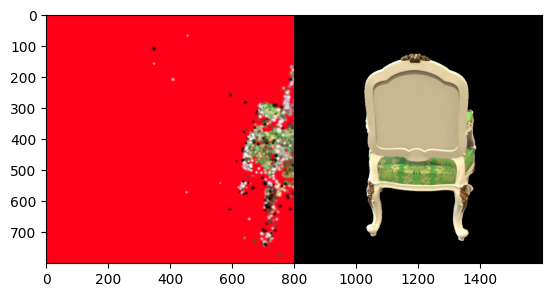

In [21]:
compare(*models[15])